In [6]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [1]:


satisfaction = pd.read_csv('data/consumer_sat_jan1980_jun2023.csv', 
                           index_col='Date', parse_dates=['Date'])

unemployment = pd.read_csv('data/unemployment_jan1980_jun2023.csv', 
                           index_col='Date', parse_dates=['Date'])

dollar = pd.read_csv('data/DX-Y.NYB.csv', index_col='Date', 
                     parse_dates=['Date'])[['Adj Close']]

dollar_h = pd.read_csv('data/2BE3C.csv', index_col='Date', 
                     parse_dates=['Date'])[['Adj Close']].resample('M').mean()


snp500 = pd.read_csv('data/HistoricalPrices.csv', skipinitialspace=True, index_col='Date', 
                     parse_dates=['Date'], date_format='%m/%d/%y')[['Close']].resample('M').mean()

snp500.index = pd.to_datetime(snp500.index)

interest_rates = pd.read_csv('data/FEDFUNDS.csv', index_col='DATE', parse_dates=['DATE'])

cpi = pd.read_csv('data/cpi_jan1980_jun2023.csv', index_col='Date', parse_dates=['Date'])

wages = pd.read_csv('data/real_wages_quarterly_1980q1_2023q2.csv').drop('Series id', axis=1)


wages['Quarter'] = wages['Quarter'].str.split('0').apply(lambda x : ''.join(x))
wages['Date'] = wages['Year'].astype('str') + wages['Quarter']
wages.drop(['Year', 'Quarter'], axis='columns', inplace=True)
wages['Date'] = pd.PeriodIndex(wages['Date'], freq='Q').to_timestamp('Q')

wages = wages.set_index('Date').resample('M').interpolate('cubicspline')
wages.index = (wages.index + pd.DateOffset(1)).to_period('M')

housing = pd.read_csv('data/ASPUS.csv')
housing['DATE'] = pd.PeriodIndex(housing['DATE'], freq='Q').to_timestamp('Q')
housing = housing.set_index('DATE').resample('M').interpolate('cubicspline')
housing.index = (housing.index + pd.DateOffset(1)).to_period('M')

NameError: name 'pd' is not defined

In [8]:
satisfaction.index = satisfaction.index.to_period('M')
unemployment.index = unemployment.index.to_period('M')
dollar.index = dollar.index.to_period('M')
dollar_h.index = dollar_h.index.to_period('M')
snp500.index = snp500.index.to_period('M')
interest_rates.index = interest_rates.index.to_period('M')
cpi.index = cpi.index.to_period('M')

unemployment['Change'] = unemployment['Value'].pct_change(4)
cpi['Inflation'] = cpi['Value'].pct_change(12)
cpi['Inflation Change'] = cpi['Inflation'].pct_change()

unemployment.dropna(inplace=True)
cpi.dropna(inplace=True)

In [95]:
snp500.index

PeriodIndex(['1980-01', '1980-02', '1980-03', '1980-04', '1980-05', '1980-06',
             '1980-07', '1980-08', '1980-09', '1980-10',
             ...
             '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04',
             '2023-05', '2023-06', '2023-07', '2023-08'],
            dtype='period[M]', name='Date', length=524)

In [9]:
timeline = pd.PeriodIndex(set(satisfaction.index) & 
                set(unemployment.index) &
                #set(dollar.index) &
                set(dollar_h.index) &
                set(snp500.index) &
                set(housing.index) &
                set(interest_rates.index) &
                set(cpi.index) &
                set(wages.index), freq='M').sort_values()

In [97]:
timeline

PeriodIndex(['1981-02', '1981-03', '1981-04', '1981-05', '1981-06', '1981-07',
             '1981-08', '1981-09', '1981-10', '1981-11',
             ...
             '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02',
             '2022-03', '2022-04', '2022-05', '2022-06'],
            dtype='period[M]', length=497)

In [36]:
(dollar_h.loc[timeline] / dollar.loc[timeline] - 1).describe()

,Adj Close
count,450.000000
mean,0.001146
std,0.010734
min,-0.033634
25%,-0.005872
50%,0.000875
75%,0.007562
max,0.054381


In [21]:
factors = pd.DataFrame(index=timeline)

factors['Unemployment'] = unemployment['Value']
factors['Unemployment Change'] = unemployment['Change'] * 100

factors['Inflation'] = cpi['Inflation'] * 100
factors['Inflation Change'] = cpi['Inflation Change'] * 100

factors['ASPUS'] = housing['ASPUS']
factors['Interest Rate'] = interest_rates['FEDFUNDS']
factors['SP500'] = snp500['Close']
factors['Dollar Strength'] = dollar_h['Adj Close']

factors['Real Wages'] = wages['Value']

Y = satisfaction.loc[timeline]

In [22]:
pre_pandemic_X = factors.loc[:'2020']
pre_pandemic_Y = Y.loc[:'2020']

In [23]:
reg = LinearRegression()
reg.fit(pre_pandemic_X, pre_pandemic_Y)

Y_pred = reg.predict(factors)
print(f'R2 score: {r2_score(pre_pandemic_Y, reg.predict(pre_pandemic_X))}')

R2 score: 0.7295297807045698


In [45]:
timeline

PeriodIndex(['1985-01', '1985-02', '1985-03', '1985-04', '1985-05', '1985-06',
             '1985-07', '1985-08', '1985-09', '1985-10',
             ...
             '2021-09', '2021-10', '2021-11', '2021-12', '2022-01', '2022-02',
             '2022-03', '2022-04', '2022-05', '2022-06'],
            dtype='period[M]', length=450)

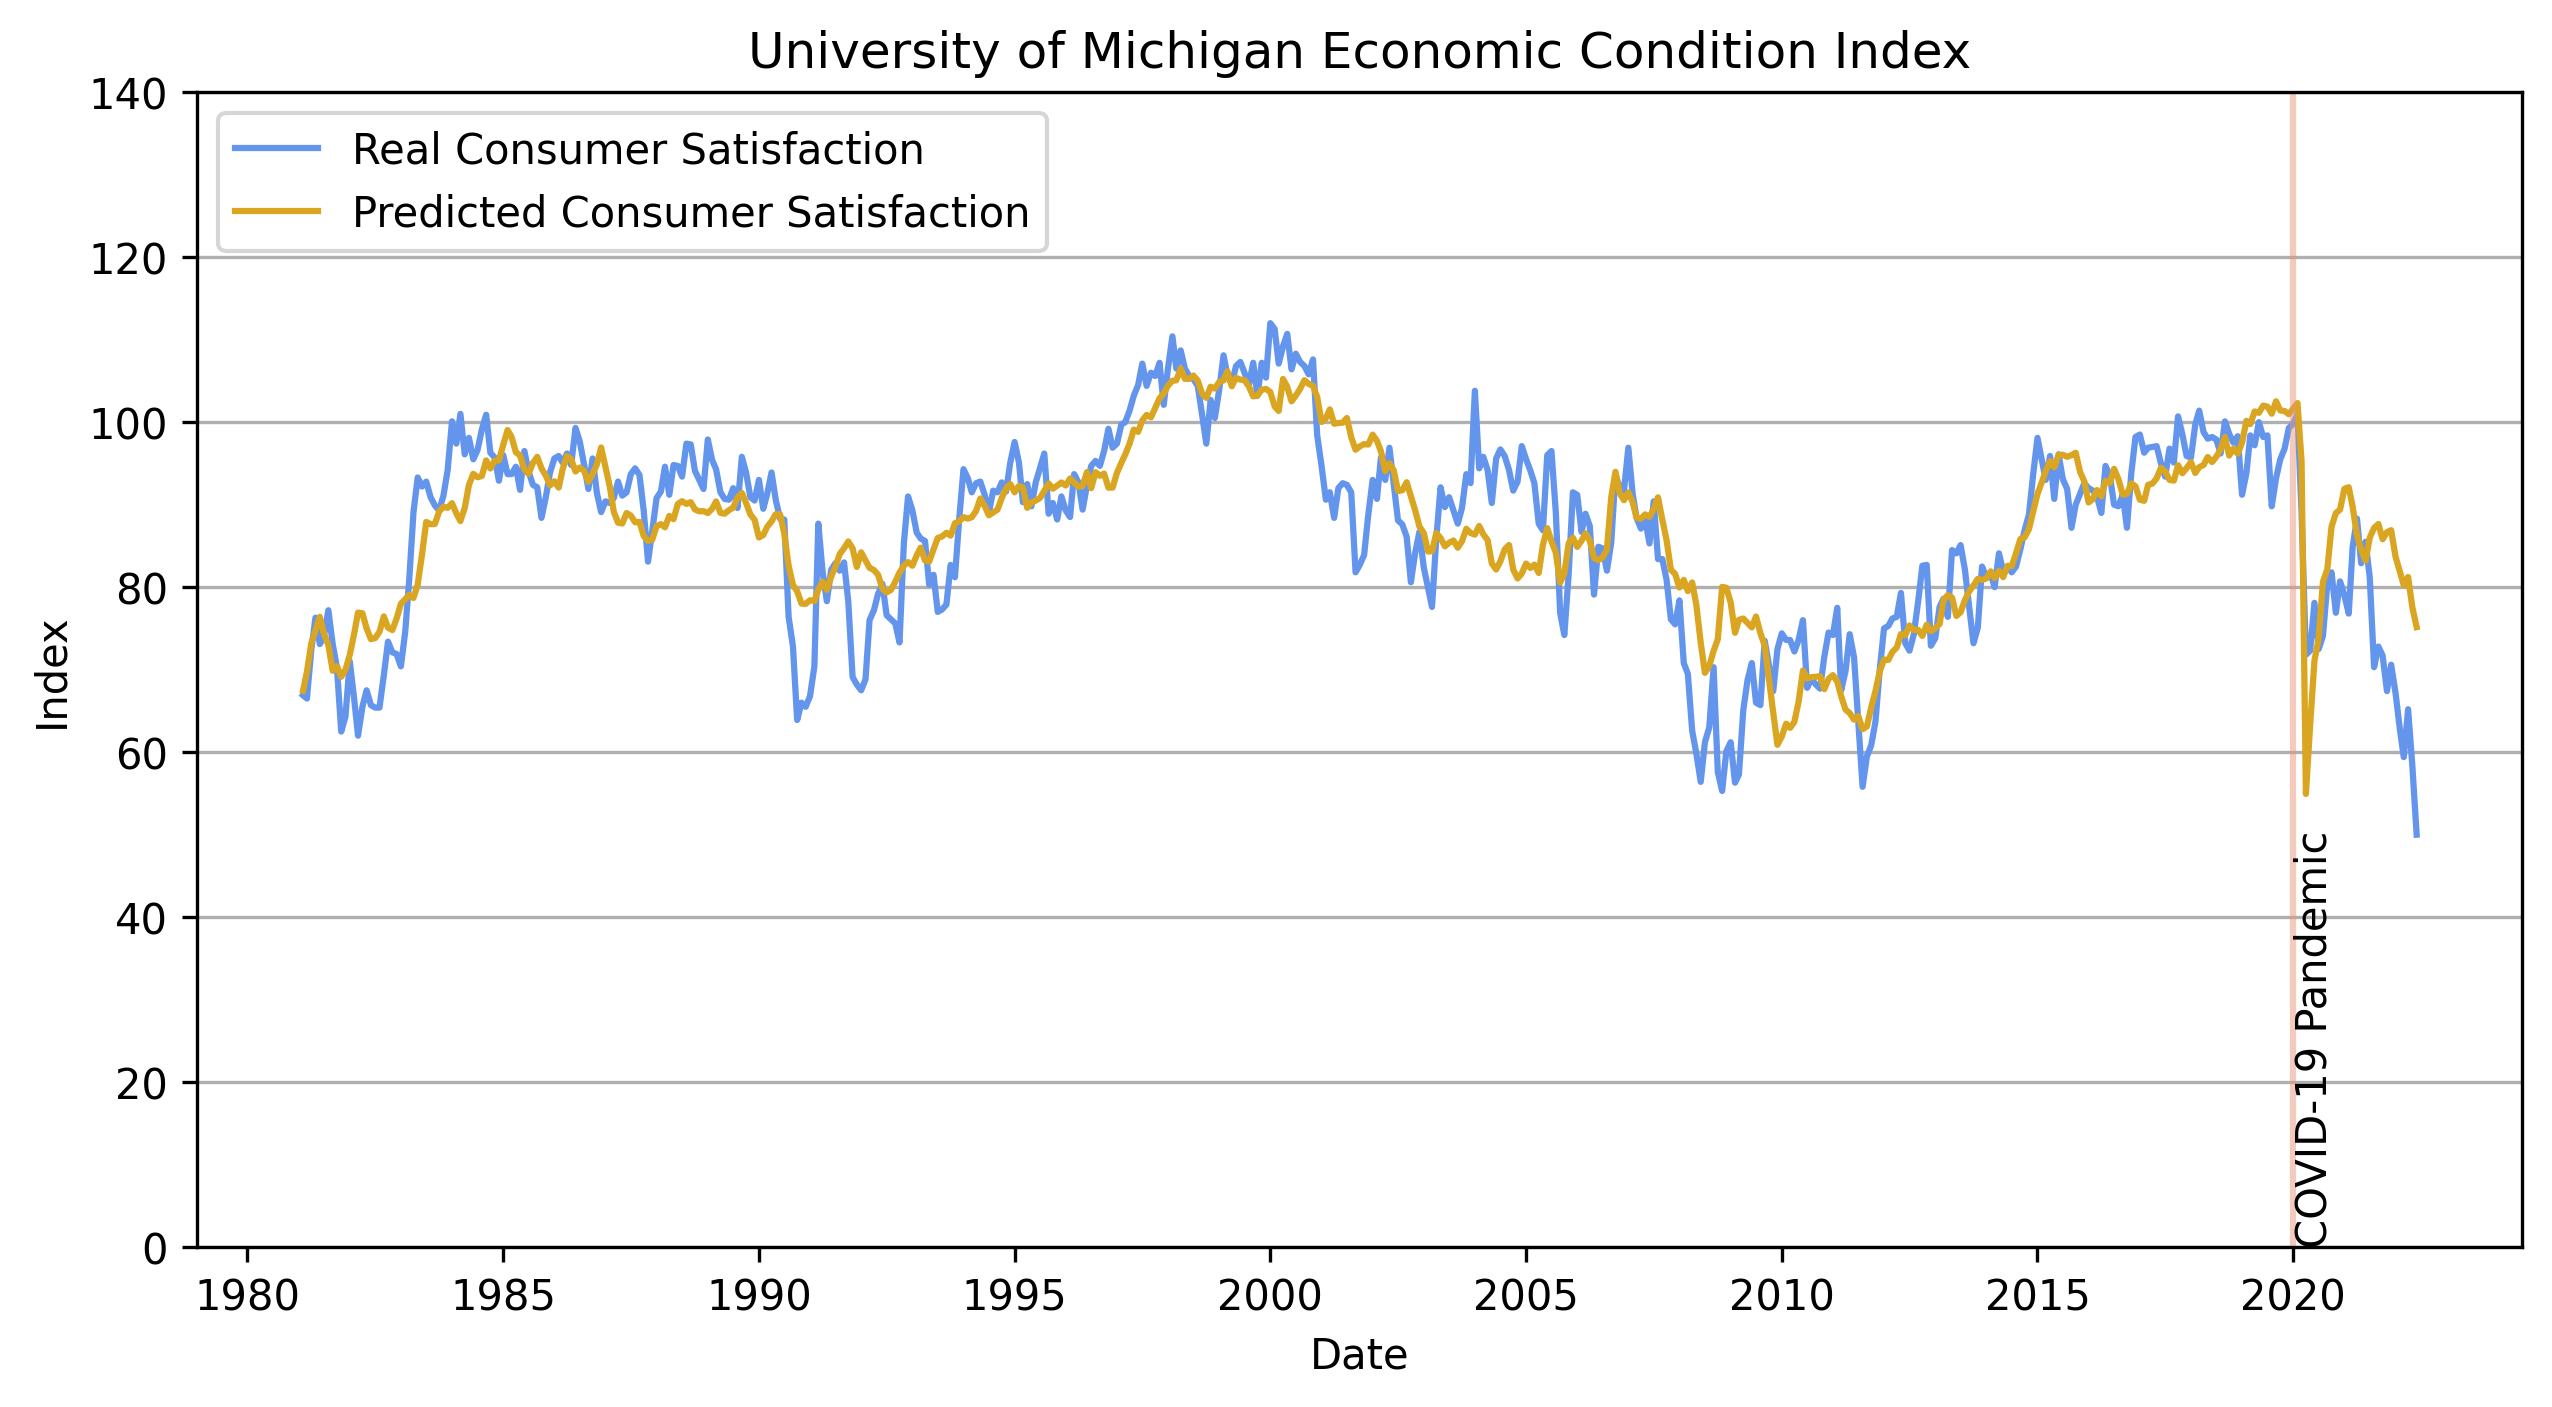

In [24]:
fig, ax = plt.subplots()

fig.set_dpi(300)
fig.set_size_inches(10, 5)

ax.set_ylim((0, 140))
ax.grid(axis='y')
ax.set_title('University of Michigan Economic Condition Index')
ax.set_xlabel('Date')
ax.set_ylabel('Index')
#fig.title('Consumer Satisfaction')

true_plot, = ax.plot(timeline.to_timestamp(), Y, color='cornflowerblue')
pred_plot, = ax.plot(timeline.to_timestamp(), reg.predict(factors), color='goldenrod')

ax.axvline(x=pd.to_datetime('2020-01'), color='darksalmon', alpha=0.5)
ax.text(s='COVID-19 Pandemic', x=pd.to_datetime('2020-01'), y=0, verticalalignment='bottom', rotation='vertical')
ax.legend([true_plot, pred_plot], ['Real Consumer Satisfaction', 'Predicted Consumer Satisfaction'])

In [20]:
reg.coef_

array([[-4.33519097e+00,  7.03698107e-03, -3.45018944e+00,
        -1.56385421e-04,  1.10326413e+00,  1.81838212e-03,
         2.48341878e-01, -1.38175745e-01]])

In [15]:
factors

,Unemployment,Unemployment Change,Inflation,Inflation Change,ASPUS,Interest Rate,SP500,Dollar Strength,Real Wages
1981-02,7.4,-1.333333,11.406844,-3.537775,80199.518816,15.93,128.395263,96.409998,314.322341
1981-03,7.4,-1.333333,10.486891,-8.064919,80356.836806,14.70,133.185000,96.591998,314.190849
1981-04,7.2,0.000000,10.000000,-4.642857,80900.000000,15.72,134.430476,99.457499,314.000000
1981-05,7.5,0.000000,9.779951,-2.200489,82026.506697,18.52,131.727000,103.985000,313.330473
1981-06,7.5,1.351351,9.552600,-2.324667,83381.859689,19.10,132.277727,107.774001,312.230746
...,...,...,...,...,...,...,...,...,...
2022-02,3.8,-15.555556,7.871064,5.229921,503749.825473,0.08,4435.980526,96.847502,361.857271
2022-03,3.6,-14.285714,8.542456,8.529872,509006.329865,0.20,4391.265217,98.697500,362.102157
2022-04,3.6,-7.692308,8.258629,-3.322537,514100.000000,0.33,4391.296000,101.120001,362.000000
2022-05,3.6,-10.000000,8.581512,3.909634,518345.079595,0.77,4040.360000,103.036000,361.018593


In [254]:
housing.drop('CSUSHPINSA', axis=1, inplace=True)

In [255]:
housing

,MSPNHSUS
DATE,
1963-01,17200.0
1963-02,17700.0
1963-03,18200.0
1963-04,18200.0
1963-05,17500.0
...,...
2023-02,433300.0
2023-03,438900.0
2023-04,410600.0


In [276]:
unemployment['change'] = unemployment.Value.pct_change(12)

In [293]:
X_train = pd.concat(objs=(
    housing.loc[train_idx, 'MSPNHSUS'],
    cpi.loc[train_idx, ['Annual', 'RateChange']],
    unemployment.loc[train_idx, ['Value', 'change']],
    wages_q.loc[train_idx, 'Value'],
    dollar.loc[train_idx, 'Adj Close'],
    fedfunds.loc[train_idx, 'FEDFUNDS'],
    snp.loc[train_idx, 'Adj Close']
    ), axis='columns')

Y_train = sat_df.loc[train_idx, 'Index']

In [308]:
X_test = pd.concat(objs=(
    housing.loc[test_idx, 'MSPNHSUS'],
    cpi.loc[test_idx, ['Annual', 'RateChange']],
    unemployment.loc[test_idx, ['Value', 'change']],
    wages_q.loc[test_idx, 'Value'],
    dollar.loc[test_idx, 'Adj Close'],
    fedfunds.loc[test_idx, 'FEDFUNDS'],
    snp.loc[test_idx, 'Adj Close']
    ), axis='columns')

Y_test = sat_df.loc[test_idx, 'Index']

In [295]:
reg = LinearRegression()

reg.fit(X_train, Y_train)

LinearRegression()

In [243]:
X_train

,MSPNHSUS,Annual,RateChange,Value,Value,Adj Close,FEDFUNDS,Adj Close
1985-01,82500.0,0.035329,-0.105299,7.3,314.000000,152.720001,8.35,179.630005
1985-02,82000.0,0.035156,-0.004883,7.2,317.000000,160.410004,8.50,181.179993
1985-03,84200.0,0.037037,0.053498,7.2,320.000000,149.179993,8.58,180.660004
1985-04,85600.0,0.036857,-0.004850,7.3,323.000000,149.699997,8.27,179.830002
1985-05,80100.0,0.037718,0.023338,7.2,322.000000,147.860001,7.97,189.550003
...,...,...,...,...,...,...,...,...
2019-08,327000.0,0.017498,-0.034053,3.7,360.666667,98.919998,2.13,2926.459961
2019-09,315700.0,0.017113,-0.021989,3.5,361.333333,99.379997,2.04,2976.739990
2019-10,322400.0,0.017640,0.030818,3.6,362.000000,97.349998,1.83,3037.560059
2019-11,328000.0,0.020513,0.162828,3.6,363.666667,98.269997,1.55,3140.979980


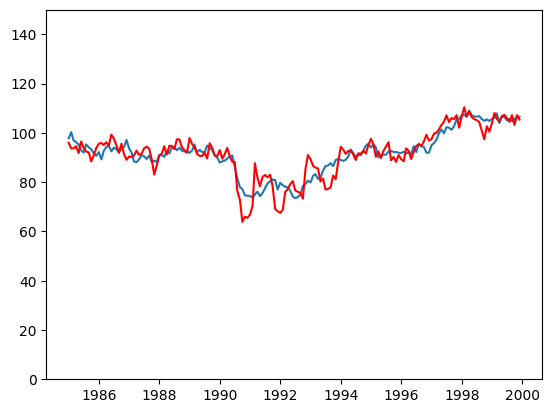

In [306]:
plt.ylim(top=150, bottom=0)
plt.plot(train_idx.to_timestamp(), reg.predict(X_train))
plt.plot(train_idx.to_timestamp(), Y_train, color='red')


(0.0, 1.0)

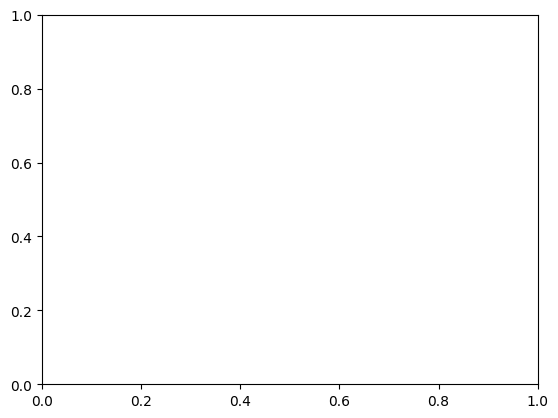

(4786.6, 20019.4)

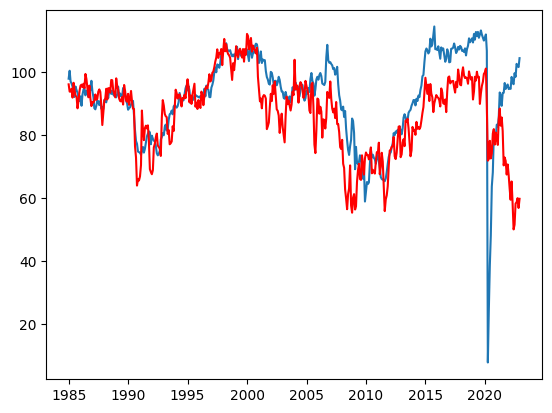

In [310]:
plt.plot(test_idx.to_timestamp(), reg.predict(X_test))
plt.plot(test_idx.to_timestamp(), Y_test, color='red')


In [265]:
from sklearn.metrics import r2_score

In [283]:
X_t = X_train[['MSPNHSUS', 'Adj Close', 'Value', 'change']]

reg = LinearRegression()

reg.fit(X_t, Y_train)

r2_score(Y_train, reg.predict(X_t))

0.5123912002295103

In [300]:

r2_






score(Y_train, reg.predict(X_train))

0.8111700727994768

In [78]:
wages_q = pd.read_csv('data/real_wages_quarterly_1980q1_2023q2.csv')[['Year', 'Period', 'Value']]
wages_m = pd.read_csv('data/real_wages_march2006_may2023.csv')[['Year', 'Period', 'Value']]

In [245]:
wages_q['Year'] = wages_q['Year'].astype('str')
wages_q['Period'] = wages_q['Period'].str.split('0').apply(lambda x: ''.join(x))

KeyError: 'Year'

In [108]:
wages_m['Year'] = wages_m['Year'].astype('str')
wages_m['Dates'] = wages_m['Year'] + '-' + wages_m['Period'].str[1:]

In [114]:
wages_m.set_index('Dates', inplace=True)
wages_q = wages_q.set_index('Date').resample('M').interpolate()


KeyError: "None of ['Dates'] are in the columns"

In [117]:
wages_m.drop(['Year', 'Period'], axis='columns', inplace=True)

In [122]:
wages_q.drop(['Year', 'Period'], axis='columns', inplace=True)

In [136]:
wages_m['Value']

Dates
2006-03    10.05
2006-04    10.10
2006-05     9.91
2006-06     9.88
2006-07     9.97
           ...  
2023-01    11.15
2023-02    11.03
2023-03    10.98
2023-04    11.10
2023-05    10.97
Name: Value, Length: 207, dtype: float64

In [198]:
fedfunds = pd.read_csv('data/FEDFUNDS.csv')

In [201]:
fedfunds.DATE = pd.to_datetime(fedfunds.DATE).dt.to_period('M')
fedfunds.set_index('DATE', inplace=True)

In [202]:
fedfunds

,FEDFUNDS
DATE,
1954-07,0.80
1954-08,1.22
1954-09,1.07
1954-10,0.85
1954-11,0.83
...,...
2023-03,4.65
2023-04,4.83
2023-05,5.06


In [182]:
dollar = pd.read_csv('data/DX-Y.NYB.csv')

In [183]:
dollar['Date'] = pd.to_datetime(dollar.Date).dt.to_period('M')

In [184]:
dollar.set_index('Date', inplace=True)

In [185]:
dollar = dollar[['Adj Close']]

In [186]:
dollar

,Adj Close
Date,
1985-01,152.720001
1985-02,160.410004
1985-03,149.179993
1985-04,149.699997
1985-05,147.860001
...,...
2023-04,101.669998
2023-05,104.320000
2023-06,102.910004


In [274]:
inf_sat_p = bokeh.plotting.figure(
    width = 500,
    height = 500,
    x_axis_label = 'Inflation rate',
    y_axis_label = 'SAT'
)

In [275]:
inf_sat_p.circle(
    x=cpi_df.RateChange * 100,
    y=sat_df.Index
)

GlyphRenderer(id='7023', ...)

In [216]:
snp = pd.read_csv('data/^SPX.csv')

In [218]:
snp.Date = pd.to_datetime(snp.Date).dt.to_period('M')
snp.set_index('Date', inplace=True)
snp = snp[['Adj Close']]